In [423]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

In [471]:
class Position:
    def __init__(self, table, player, opponent, parent) -> None:
        self.table_tokens = table
        self.max_tokens = player
        self.min_tokens = opponent
        self.legal_moves = self.set_legal_moves()
        self.cost = None
        self.parent = parent
        self.children = []

    def set_legal_moves(self):
        if self.table_tokens >= 4:
            return [3, 2, 1]
        elif self.table_tokens == 3:
            return [2, 1]
        else:
            return [1]

    def is_terminal_position(self):
        return True if self.table_tokens == 1 else False

    def set_cost(self, cost):
        self.cost = cost

    def next_best_move(self):
        same_cost_children = [child for child in self.children if child.cost == self.cost]
        return random.choice(same_cost_children)

    def __str__(self) -> str:
        return f'[TABLE: {self.table_tokens}, MAX: {self.max_tokens}, MIN: {self.min_tokens}, COST: {self.cost}]'

In [425]:
def random_heuristic(position: Position, is_max_round: bool, n):
    return random.uniform(-1, 1)

In [426]:
def naive_heuristic(position: Position, is_max_round: bool, n):
    if position.table_tokens in 1 and is_max_round:
        return -1
    elif position.table_tokens == 1 and not is_max_round:
        return 1
    else:
        return 0

In [502]:
def my_heuristic(position: Position, is_max_round: bool, n):
    if position.table_tokens == (1, 4) and is_max_round:
        return -1
    elif position.table_tokens == (1, 4) and not is_max_round:
        return 1
    else:
        return -position.table_tokens / n if is_max_round else position.table_tokens / n

In [428]:
def minimax(position : Position, depth : int, alpha : float, beta : float, is_max_round : bool, heuristic : callable, n):

    if depth == 0 or position.is_terminal_position():
        cost = heuristic(position, is_max_round, n)
        position.set_cost(cost)
        return cost

    if is_max_round:
        max_eval = -math.inf
        for k in position.legal_moves:
            child_position = Position(position.table_tokens - k, position.max_tokens + k, position.min_tokens, position)
            position.children.append(child_position)
            eval = minimax(child_position, depth - 1, alpha, beta, False, heuristic, n)
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        position.set_cost(max_eval)
        return max_eval
    else:
        min_eval = math.inf
        for k in position.legal_moves:
            child_position = Position(position.table_tokens - k, position.max_tokens, position.min_tokens + k, position)
            position.children.append(child_position)
            eval = minimax(child_position, depth - 1, alpha, beta, True, heuristic, n)
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        position.set_cost(min_eval)
        return min_eval


In [482]:
class Game:
    def __init__(self, n : int, max_depth : int, min_depth : int, is_max_round : bool, max_heuristic : callable, min_heutistic : callable) -> None:
        self.current_position = Position(max(n, 4), 0, 0, None)
        self.max_depth = max(max_depth, 1)
        self.min_depth = max(min_depth, 1)
        self.is_max_round = is_max_round
        self.max_heuristic = max_heuristic
        self.min_heuristic = min_heutistic
        self.n = max(n, 4)

    def play(self):

        while self.current_position.table_tokens != 1:

            if self.is_max_round:
                minimax(self.current_position, self.max_depth, -math.inf, math.inf, True, self.max_heuristic, self.n)
                self.is_max_round = False
            else:
                minimax(self.current_position, self.min_depth, -math.inf, math.inf, False, self.min_heuristic, self.n)
                self.is_max_round = True

            self.current_position = self.current_position.next_best_move()

        if self.is_max_round:
            return 'Min won!'
        else:
            return 'Max won!'

Parametry do uwzględnienia:

- N jako liczba losowana z zakresu 8-20 (z rozkładem jednostajnym)
- Kto zaczyna (max czy min)
- Głębokość szukania dla MAX 5 liczb całkowitych liniowow od 1 do 30
- Głębokość szukania dla MIN 5 liczb całkowitych liniowow od 1 do 30
- Heurystyka randomowa, naiwna i moja

In [512]:
n_values = [int(random.uniform(8, 20)) for _ in range(500)]
max_depth = 5
min_depth = 20
is_max_round = False
max_heuristic = naive_heuristic
min_heuristic = my_heuristic
results = []
for n in n_values:
    game = Game(n, max_depth, min_depth, is_max_round, max_heuristic, min_heuristic)
    results.append(game.play())

print("Max won " + str(results.count('Max won!')) + " times")
print("Min won " + str(results.count('Min won!')) + " times")

Max won 244 times
Min won 256 times


In [500]:
def draw_graphs(max_heuristic, min_heuristic):

    # Make grid of matplotlib graphs 5 x 5
    fig, axs = plt.subplots(5, 5, figsize=(25, 25), layout='constrained')

    for i, max_depth in enumerate(np.linspace(1, 30, 5, dtype=int).tolist()):
        for j, min_depth in enumerate(np.linspace(1, 30, 5, dtype=int).tolist()):

            who_starts = ("MAX STARTS", "MIN STARTS")
            results = {'max_won': [], 'min_won': []}

            for round in [True, False]:
                n_values = [int(random.uniform(8, 20)) for _ in range(500)]
                game_results = []
                for n in n_values:
                    game = Game(n, max_depth, min_depth, round, max_heuristic, min_heuristic)
                    game_results.append(game.play())
                results['max_won'].append(game_results.count('Max won!'))
                results['min_won'].append(game_results.count('Min won!'))

            x = np.arange(len(who_starts))
            width = 0.25
            multiplier = 0

            for attribute, measurement in results.items():
                offset = width * multiplier
                rects = axs[i, j].bar(x + offset, measurement, width, label=attribute)
                axs[i, j].bar_label(rects, padding=2)
                multiplier += 1

            axs[i, j].set_ylabel('Number of wins')
            axs[i, j].set_title(f'Max depth: {max_depth}, Min depth: {min_depth}')
            axs[i, j].set_xticks(x + width/2, who_starts)
            axs[i, j].legend(loc='upper left', ncols=2)
            axs[i, j].set_ylim(0, 500)

    plt.show()

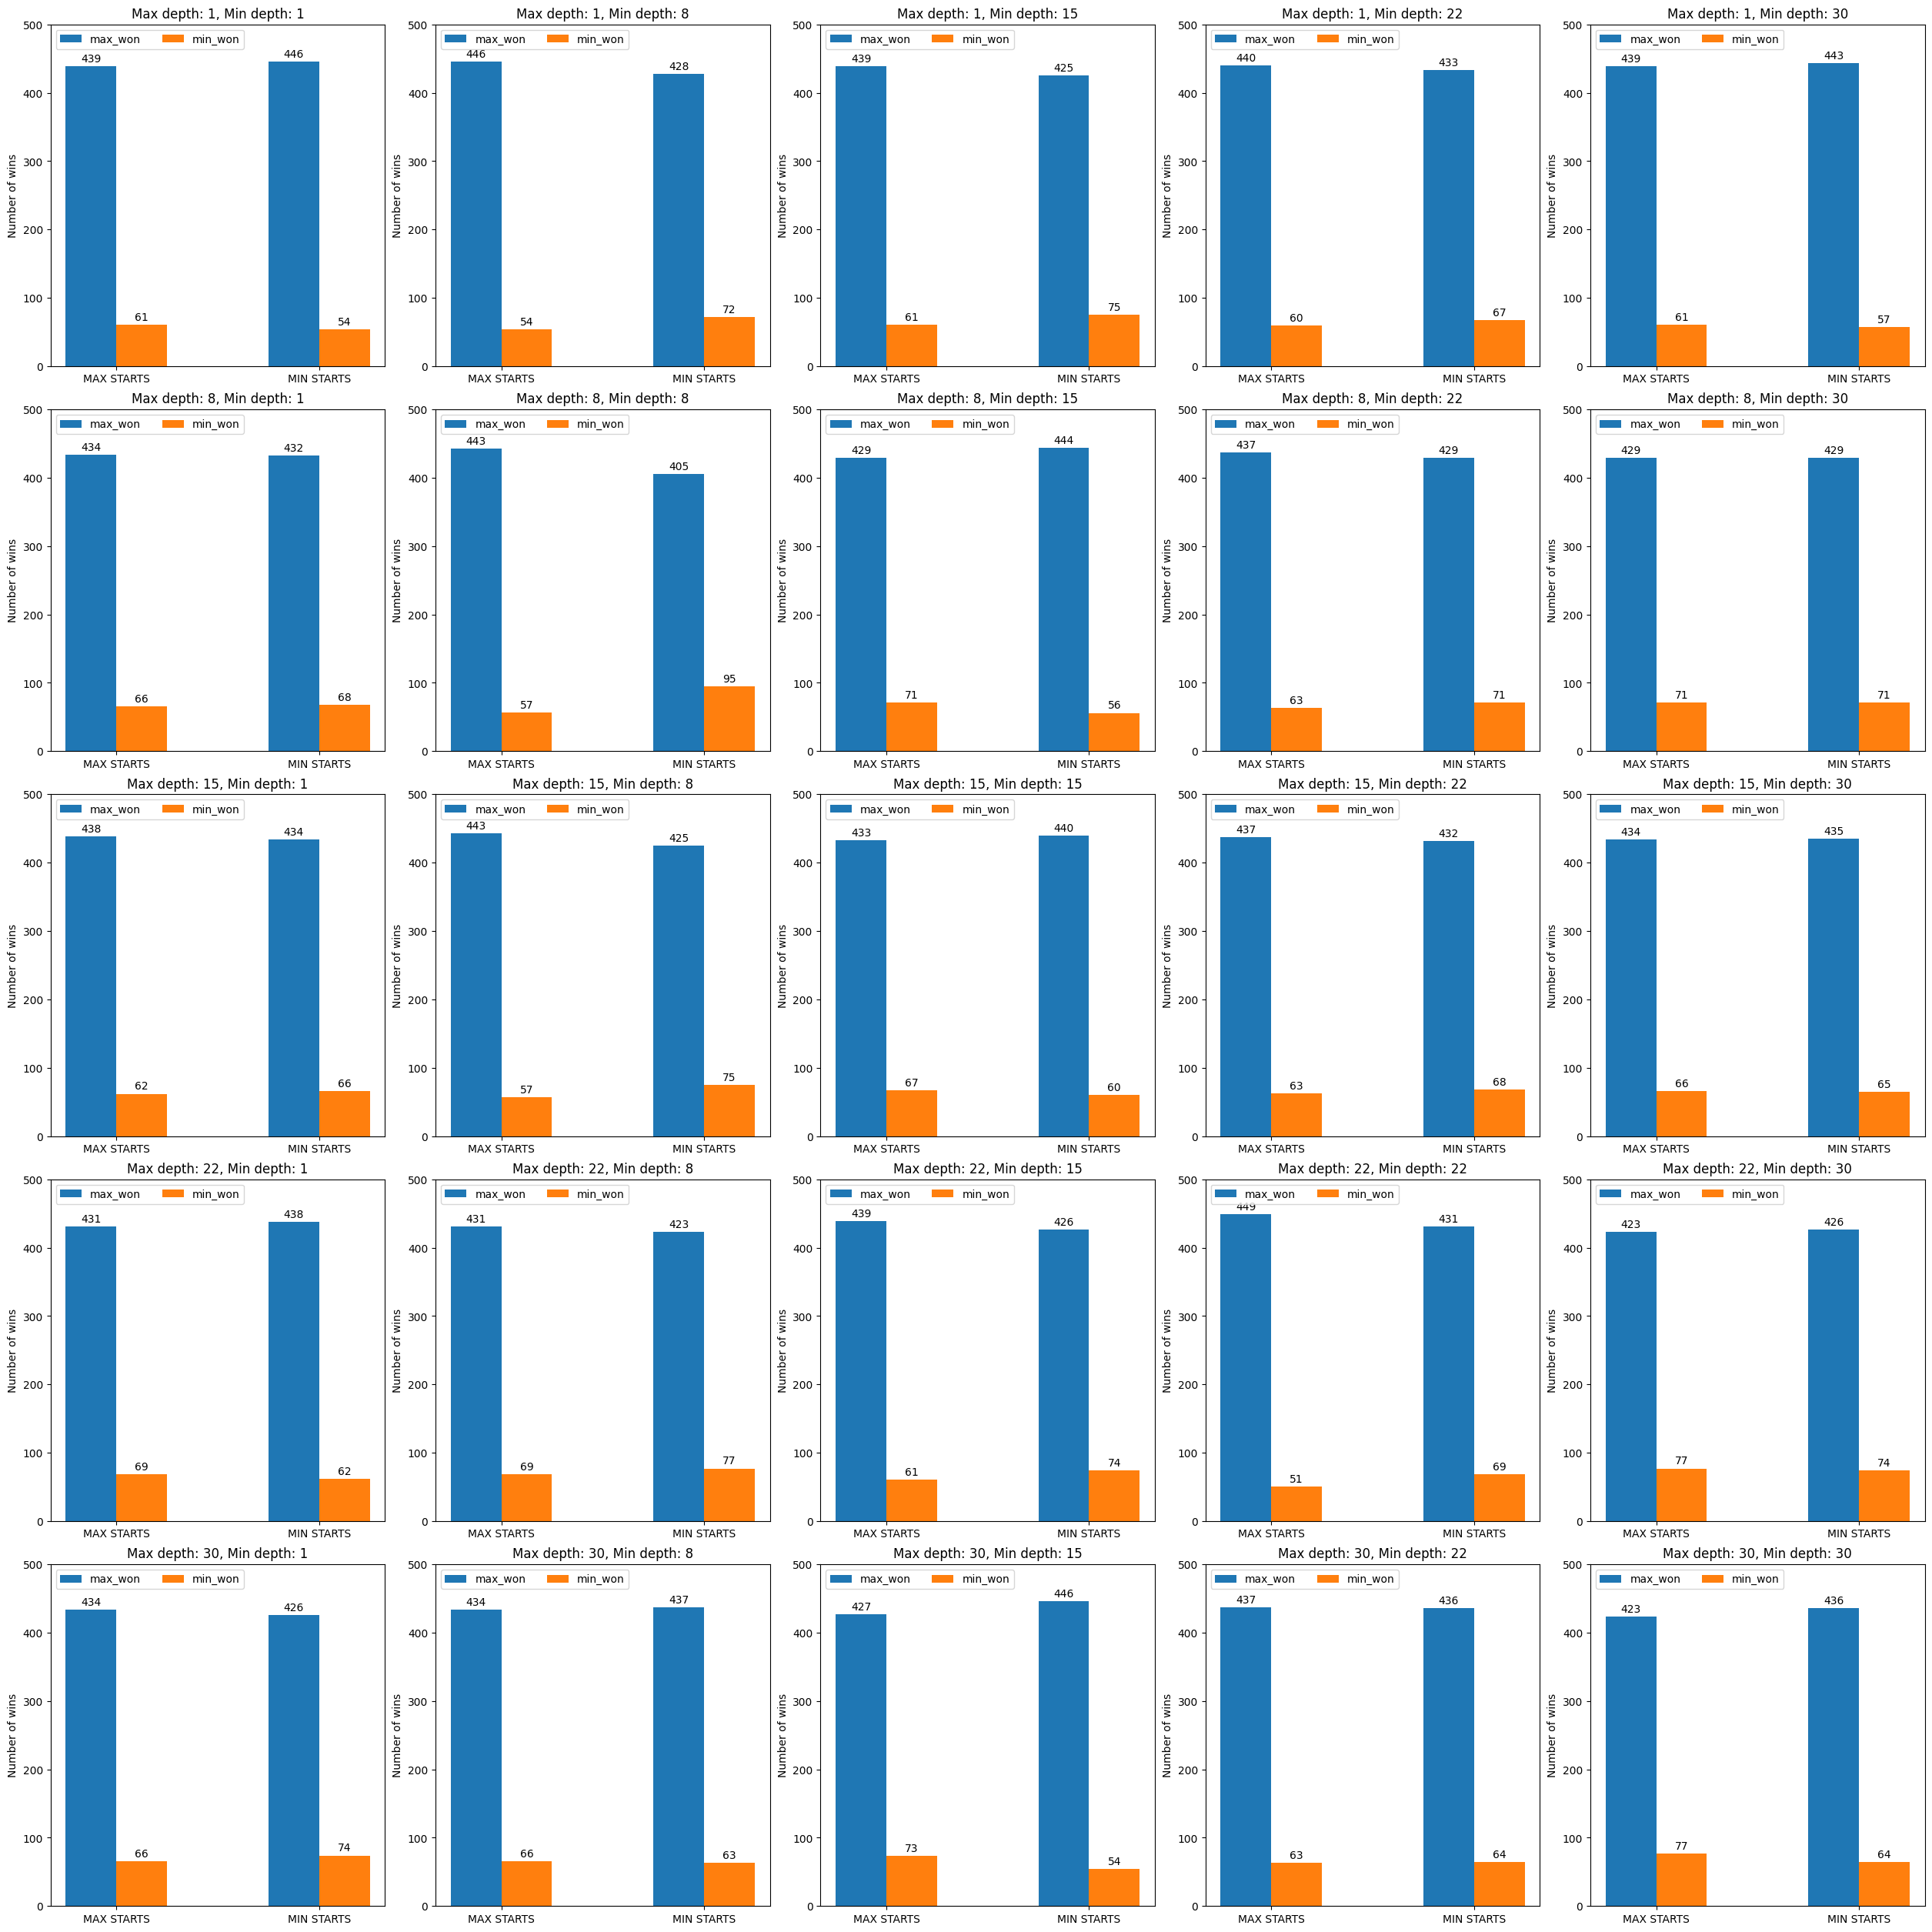

In [501]:
draw_graphs(my_heuristic, random_heuristic)

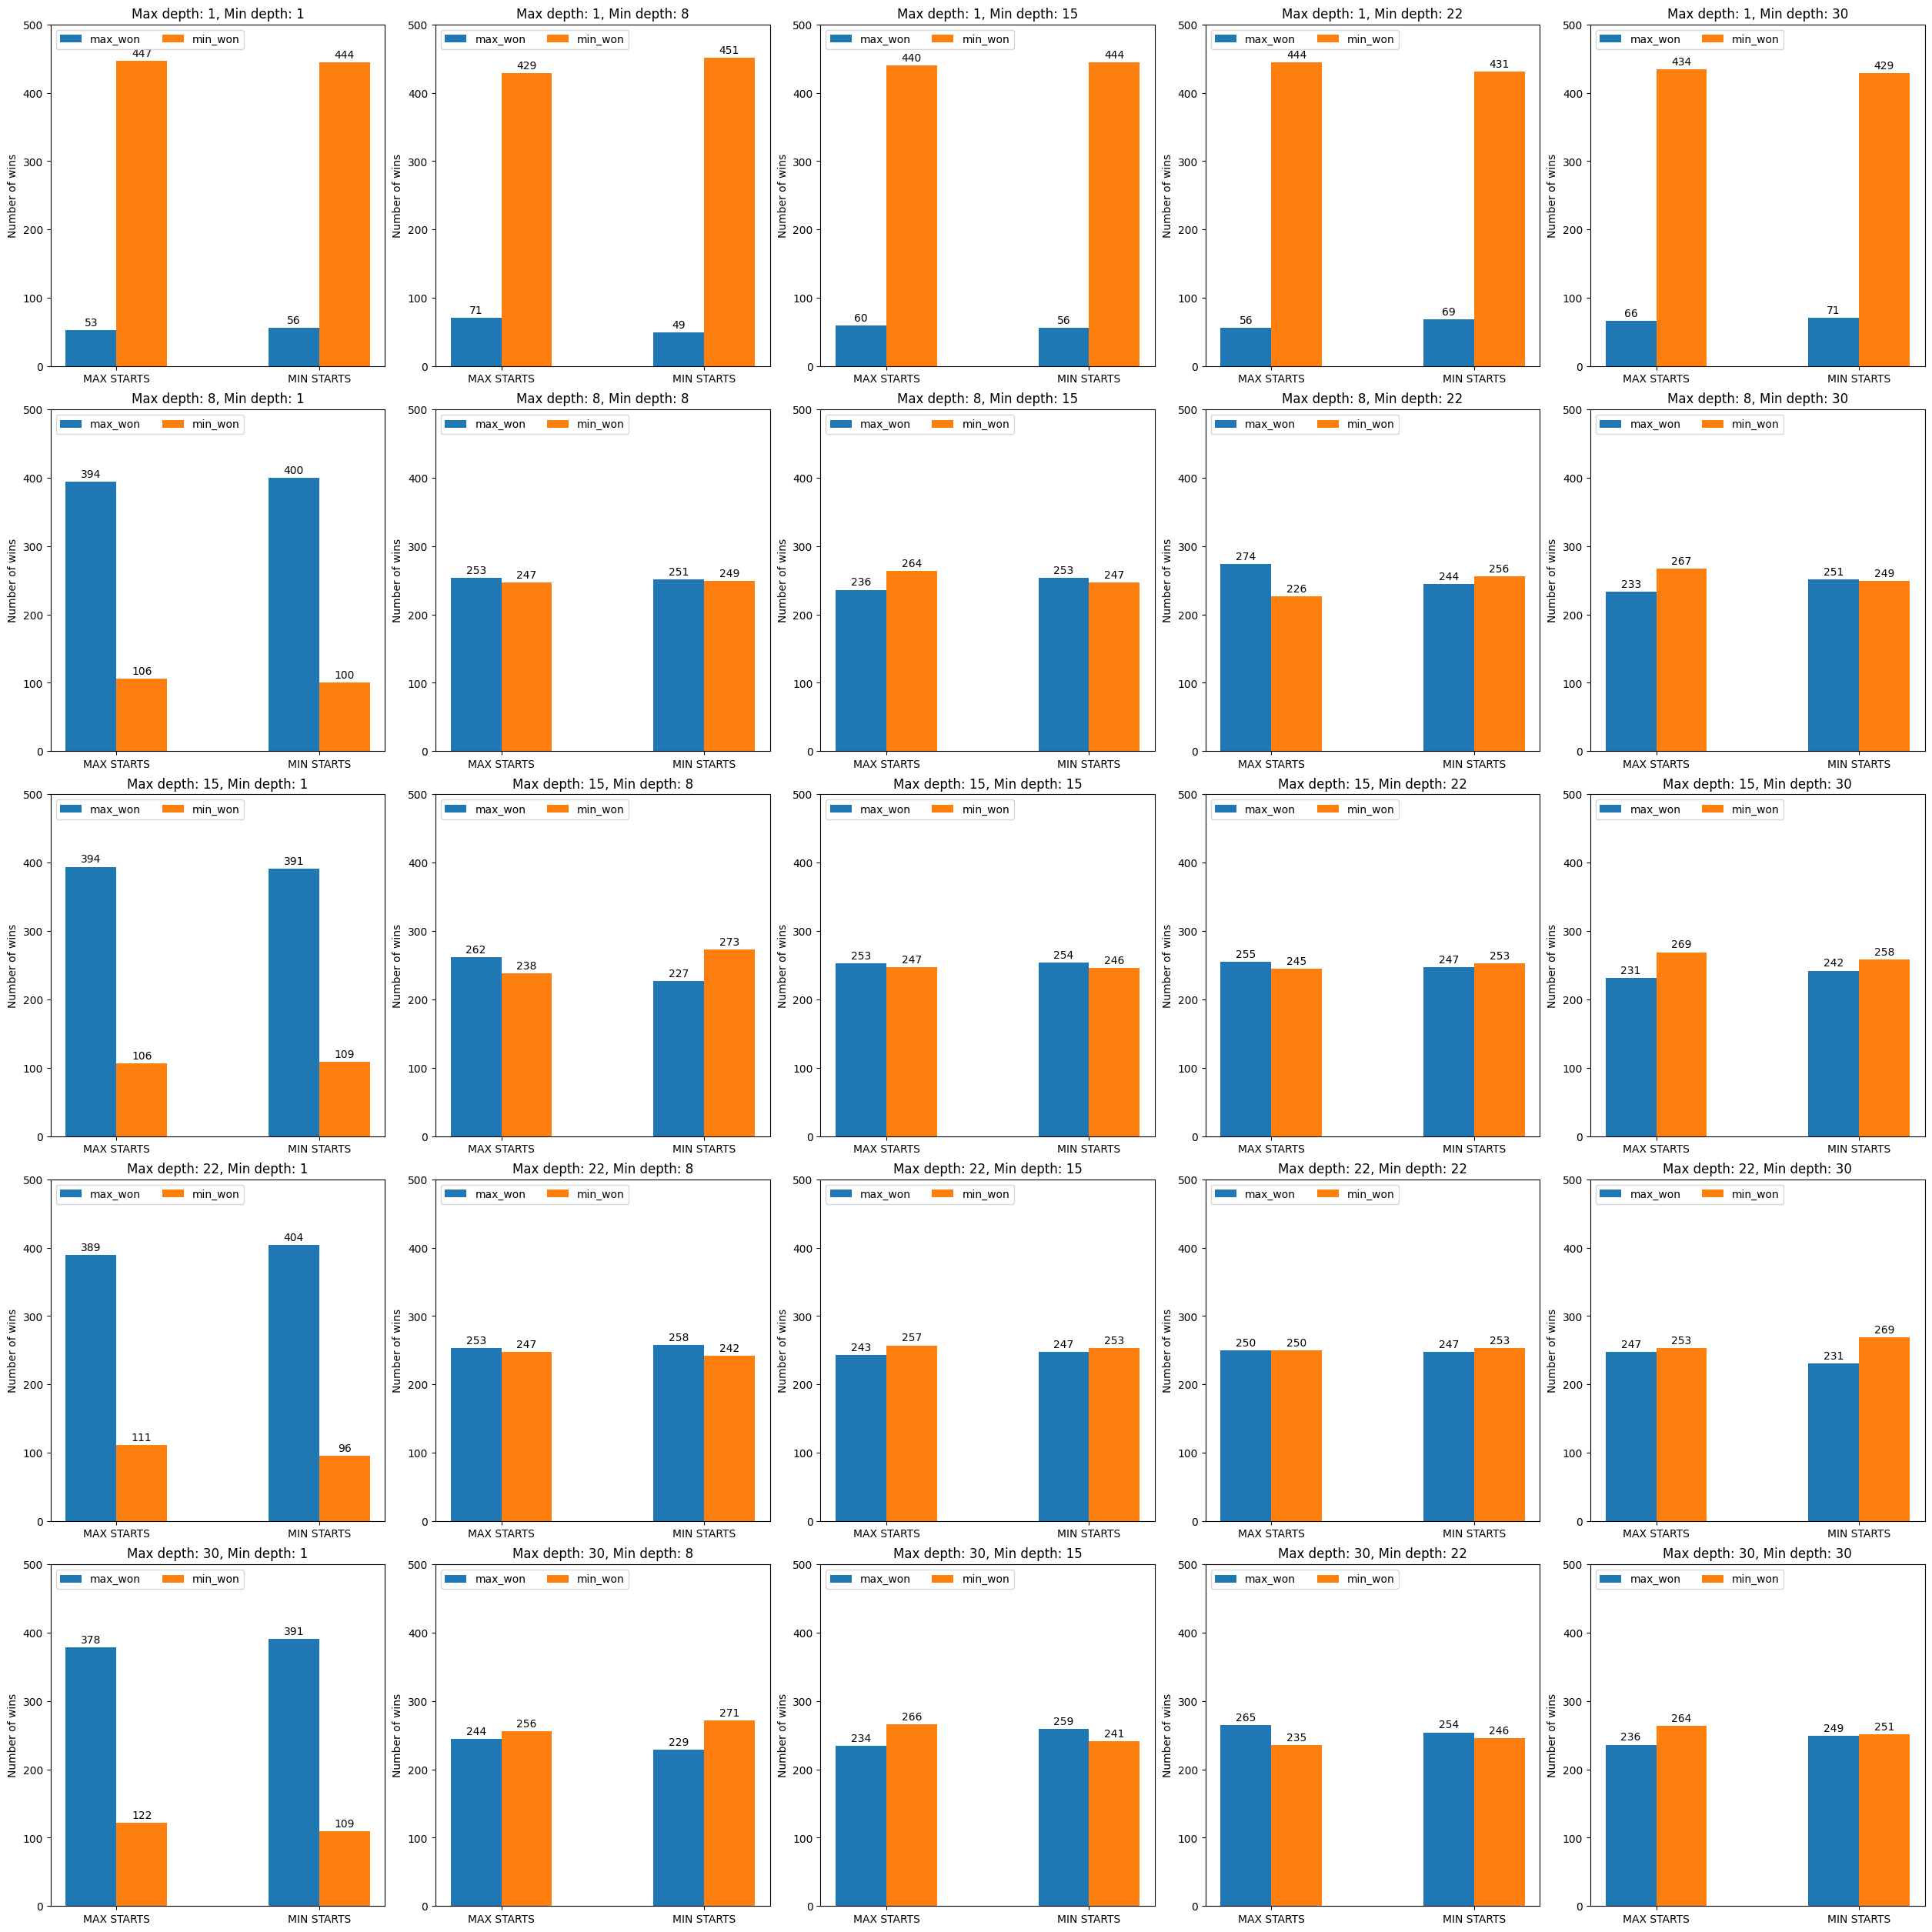

In [503]:
draw_graphs(my_heuristic, naive_heuristic)